In [1]:
!pip install imbalanced-learn librosa pandas matplotlib scikeras resampy

## Step 1 : Load and Explore a Sample of the Dataset

Sampled Dataset Size: 2100
                                                   path  \
1090  backend/data/Toronto Emotional Speech Set\OAF_...   
2515  backend/data/Toronto Emotional Speech Set\YAF_...   
991   backend/data/Toronto Emotional Speech Set\OAF_...   
1470  backend/data/Toronto Emotional Speech Set\YAF_...   
2540  backend/data/Toronto Emotional Speech Set\YAF_...   

                     emotion  
1090   OAF_Pleasant_surprise  
2515  YAF_pleasant_surprised  
991              OAF_neutral  
1470               YAF_angry  
2540  YAF_pleasant_surprised  


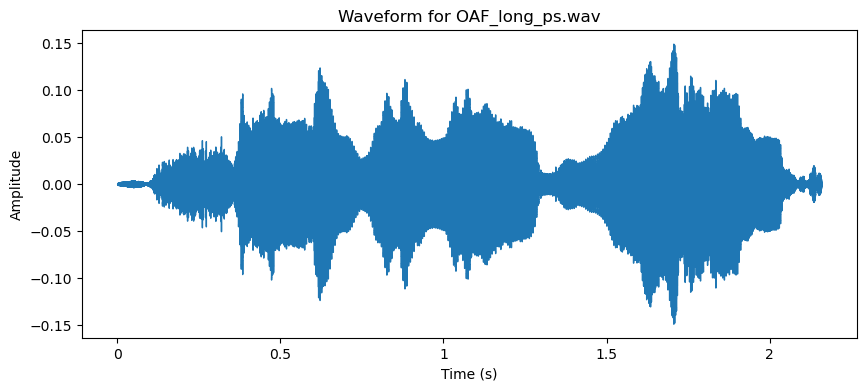

In [3]:
# Import necessary libraries
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Setting the dataset path
dataset_path = r'backend/data/Toronto Emotional Speech Set'

# Function to load dataset information
def load_dataset(dataset_path):
    emotions = os.listdir(dataset_path)
    data = []
    for emotion in emotions:
        emotion_path = os.path.join(dataset_path, emotion)
        for file in os.listdir(emotion_path):
            if file.endswith('.wav'):
                file_path = os.path.join(emotion_path, file)
                data.append({"path": file_path, "emotion": emotion})
    return pd.DataFrame(data)

# Loading full dataset
data = load_dataset(dataset_path)

# Taking a random sample -> 50% of the data
sampled_data = data.sample(frac=0.75, random_state=61)
print(f"Sampled Dataset Size: {len(sampled_data)}")
print(sampled_data.head())

# Sample visualization
def visualize_waveform(file_path):
    signal, sr = librosa.load(file_path, sr=None)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(signal, sr=sr)
    plt.title(f"Waveform for {os.path.basename(file_path)}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

# Visualizing one sample
sample_file = sampled_data['path'].iloc[0]
visualize_waveform(sample_file)

## Step 2 : Preprocessing

In [5]:
from sklearn.model_selection import train_test_split

# Function to preprocess a single audio file
def preprocess_audio(file_path, target_sr=22050):
    signal, sr = librosa.load(file_path, sr=target_sr)  # Load and resample audio
    normalized_signal = librosa.util.normalize(signal)  # Normalize amplitude
    return normalized_signal, sr

# Preprocessing a sample file for demonstration
sample_signal, sample_sr = preprocess_audio(sample_file)
print(f"Processed signal shape: {sample_signal.shape}, Sampling rate: {sample_sr}")

# Splitting the dataset into training and testing sets
def split_data(data, test_size=0.2, random_state=48):
    return train_test_split(data, test_size=test_size, random_state=random_state, stratify=data['emotion'])

train_data, test_data = split_data(sampled_data)
print(f"Training set size: {len(train_data)}, Testing set size: {len(test_data)}")

Processed signal shape: (47614,), Sampling rate: 22050
Training set size: 1680, Testing set size: 420


## Step 3 : Feature Extraction

In [7]:
# Function to extract MFCC features from an audio file
def extract_features(file_path, n_mfcc=10, n_fft=2048, hop_length=512):
    signal, sr = preprocess_audio(file_path)  # Preprocess the audio
    # Computing MFCC features
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    mfccs_mean = mfccs.mean(axis=1)  # Average MFCCs over time
    return mfccs_mean

# Testing the updated function with a sample file
sample_features = extract_features(sample_file)
print(f"Extracted MFCC features: {sample_features}")


# Extracting features for the training and testing datasets
def extract_dataset_features(data, n_mfcc=10):
    features = []
    labels = []
    for _, row in data.iterrows():
        mfccs = extract_features(row['path'], n_mfcc=n_mfcc)
        features.append(mfccs)
        labels.append(row['emotion'])
    return np.array(features), np.array(labels)

# Extracting features for training and testing sets
X_train, y_train = extract_dataset_features(train_data)
X_test, y_test = extract_dataset_features(test_data)

# Checking feature shapes
print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Extracted MFCC features: [-215.05843     95.68583     16.999685    -9.902915   -14.248891
   -3.8871424  -11.367378     2.5047097  -16.41139     -5.0569096]
Training features shape: (1680, 10)
Testing features shape: (420, 10)


## Step 4 : Dimensionality Reduction

In [9]:
from sklearn.decomposition import PCA

# Function to apply PCA for dimensionality reduction
def apply_pca(X, n_components=10):
    pca = PCA(n_components=n_components)
    X_reduced = pca.fit_transform(X)
    return X_reduced, pca

# Applying PCA to training and testing features
n_components = 10  # You can experiment with this value
X_train_reduced, pca = apply_pca(X_train, n_components=n_components)
X_test_reduced = pca.transform(X_test)

# Checking the shape of the reduced features
print(f"Reduced training features shape: {X_train_reduced.shape}")
print(f"Reduced testing features shape: {X_test_reduced.shape}")

# Explained variance ratio
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance retained: {sum(pca.explained_variance_ratio_):.2f}")

Reduced training features shape: (1680, 10)
Reduced testing features shape: (420, 10)
Explained variance ratio: [0.4148398  0.30342907 0.12904114 0.0577662  0.03748384 0.0194382
 0.01384734 0.00975459 0.00783491 0.00656491]
Total variance retained: 1.00


## Step 5 : Building Classifiers

In [11]:
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Step 1: Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_reduced)
X_test_scaled = scaler.transform(X_test_reduced)

# Step 2: Balancing the dataset using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Step 3: Function to train and evaluate models
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Evaluate the model
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.2f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=1))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

Logistic Regression Results:
Accuracy: 0.88

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.78      0.70      0.74        30
 OAF_Pleasant_surprise       0.60      0.58      0.59        31
               OAF_Sad       0.93      1.00      0.97        28
             OAF_angry       0.85      0.93      0.89        30
           OAF_disgust       0.82      0.74      0.78        31
             OAF_happy       0.66      0.72      0.69        29
           OAF_neutral       1.00      0.97      0.98        30
             YAF_angry       0.90      0.90      0.90        30
           YAF_disgust       1.00      0.97      0.98        29
              YAF_fear       0.97      0.97      0.97        29
             YAF_happy       0.97      0.97      0.97        29
           YAF_neutral       0.97      1.00      0.98        31
YAF_pleasant_surprised       0.90      0.90      0.90        31
               YAF_sad       1.00  

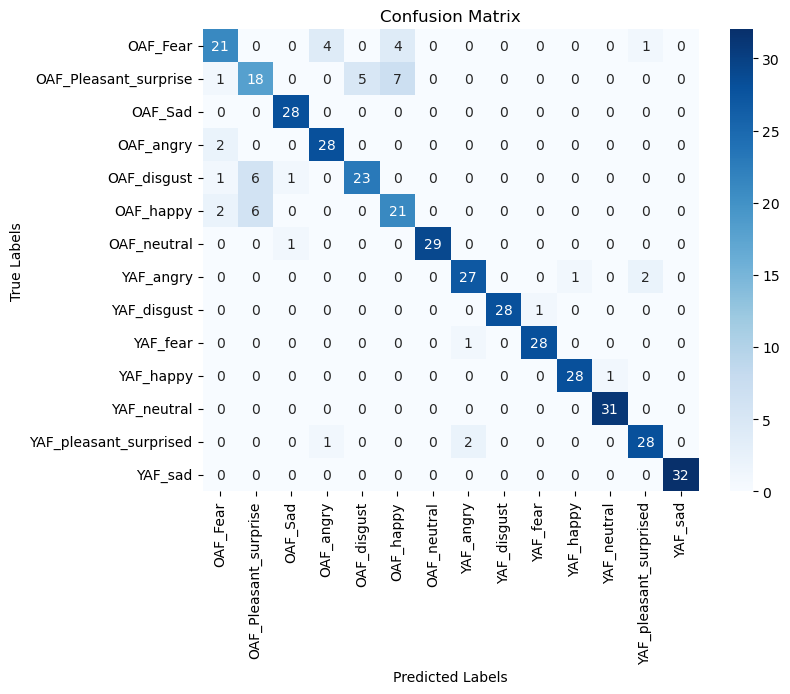

In [12]:
# Step 4: Training and evaluating classifiers
# 1) Logistic Regression
print("Logistic Regression Results:")
log_reg = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=37)
train_and_evaluate_model(log_reg, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


Support Vector Machines Results:
Accuracy: 0.91

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.71      0.73      0.72        30
 OAF_Pleasant_surprise       0.75      0.68      0.71        31
               OAF_Sad       0.93      1.00      0.97        28
             OAF_angry       0.87      0.90      0.89        30
           OAF_disgust       0.93      0.81      0.86        31
             OAF_happy       0.75      0.83      0.79        29
           OAF_neutral       0.97      0.97      0.97        30
             YAF_angry       0.97      0.97      0.97        30
           YAF_disgust       0.97      0.97      0.97        29
              YAF_fear       1.00      0.97      0.98        29
             YAF_happy       1.00      1.00      1.00        29
           YAF_neutral       1.00      1.00      1.00        31
YAF_pleasant_surprised       0.97      1.00      0.98        31
               YAF_sad       1

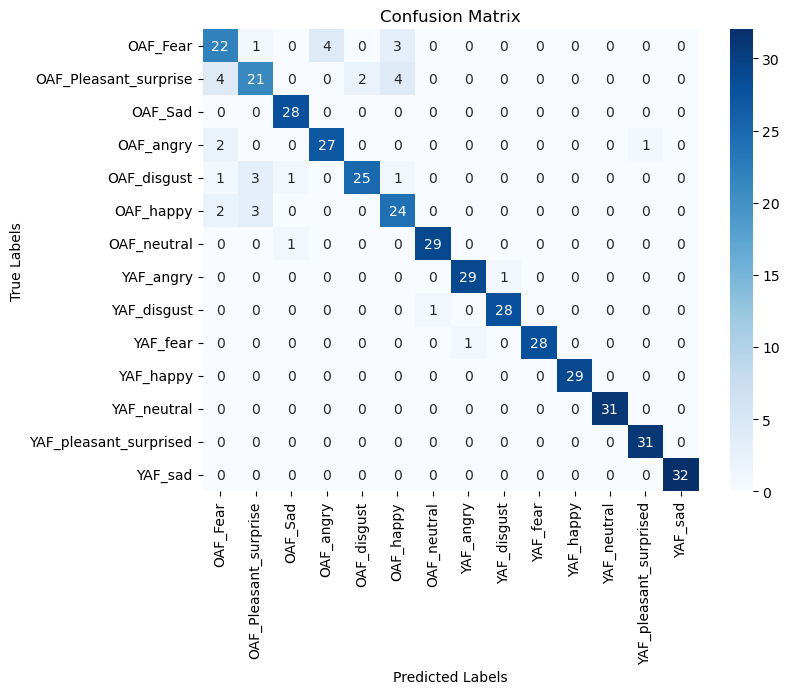

In [13]:
# 2) Support Vector Machines
print("\nSupport Vector Machines Results:")
svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
train_and_evaluate_model(svm, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


K-Nearest Neighbors Results:
Accuracy: 0.85

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.60      0.70      0.65        30
 OAF_Pleasant_surprise       0.55      0.55      0.55        31
               OAF_Sad       0.93      0.89      0.91        28
             OAF_angry       0.87      0.87      0.87        30
           OAF_disgust       0.75      0.48      0.59        31
             OAF_happy       0.71      0.86      0.78        29
           OAF_neutral       0.91      0.97      0.94        30
             YAF_angry       0.83      0.97      0.89        30
           YAF_disgust       0.90      0.93      0.92        29
              YAF_fear       1.00      0.90      0.95        29
             YAF_happy       1.00      0.93      0.96        29
           YAF_neutral       1.00      0.97      0.98        31
YAF_pleasant_surprised       1.00      0.94      0.97        31
               YAF_sad       0.97 

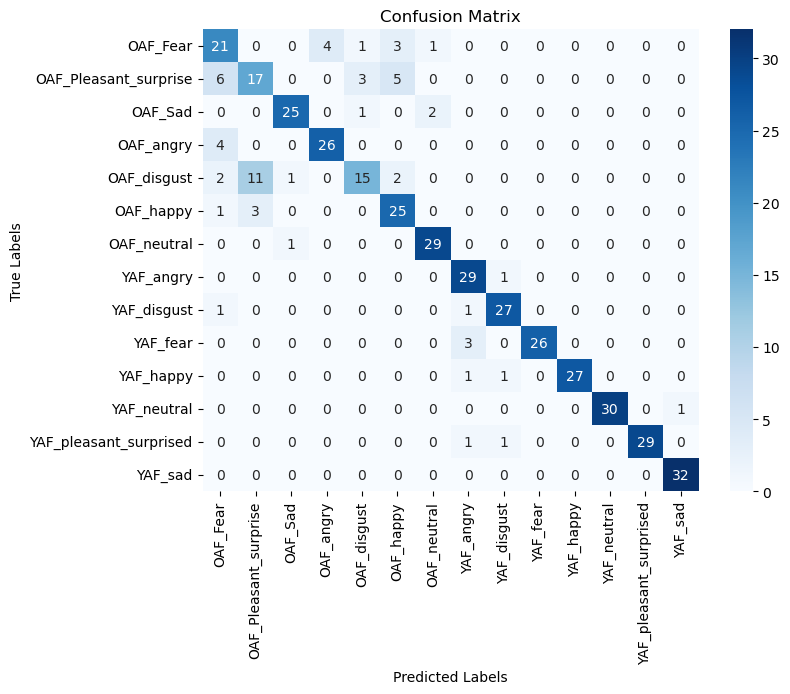

In [14]:
# 3) K-Nearest Neighbors
print("\nK-Nearest Neighbors Results:")
knn = KNeighborsClassifier(n_neighbors=5)
train_and_evaluate_model(knn, X_train_balanced, y_train_balanced, X_test_scaled, y_test)


Random Forest Results:
Accuracy: 0.87

Classification Report:
                        precision    recall  f1-score   support

              OAF_Fear       0.70      0.70      0.70        30
 OAF_Pleasant_surprise       0.63      0.55      0.59        31
               OAF_Sad       0.97      1.00      0.98        28
             OAF_angry       0.84      0.90      0.87        30
           OAF_disgust       0.77      0.74      0.75        31
             OAF_happy       0.73      0.76      0.75        29
           OAF_neutral       1.00      0.97      0.98        30
             YAF_angry       0.88      0.93      0.90        30
           YAF_disgust       0.87      0.90      0.88        29
              YAF_fear       0.93      0.90      0.91        29
             YAF_happy       1.00      0.90      0.95        29
           YAF_neutral       0.91      0.97      0.94        31
YAF_pleasant_surprised       0.94      0.94      0.94        31
               YAF_sad       0.97      1

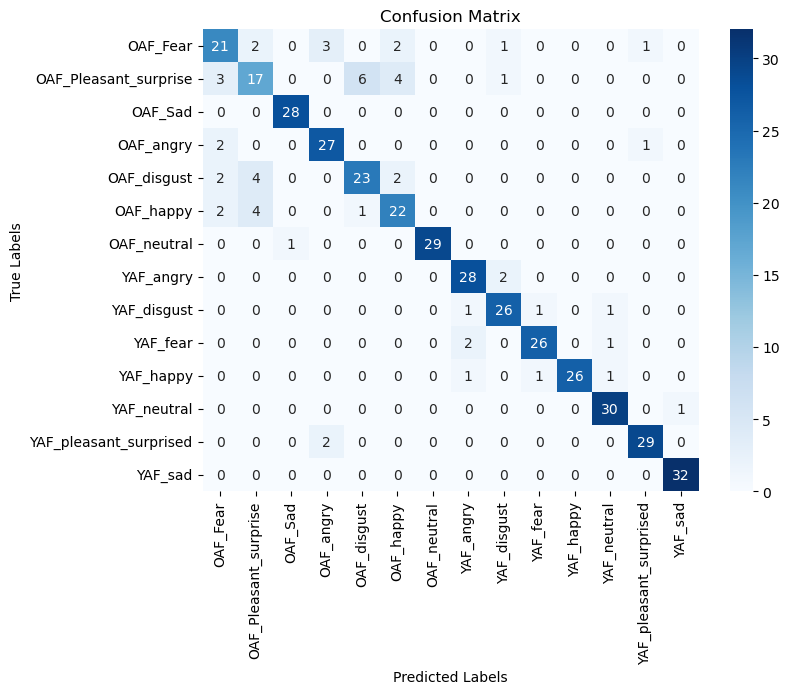

In [15]:
# 4) Random Forest Classifier
print("\nRandom Forest Results:")
rf = RandomForestClassifier(class_weight='balanced', random_state=46)
train_and_evaluate_model(rf, X_train_balanced, y_train_balanced, X_test_scaled, y_test)

## Step 6: Evaluation and Model Selection

Evaluating model: Logistic Regression
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Evaluating model: SVM
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Evaluating model: KNN
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Evaluating model: Random Forest
y_test type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
y_pred type: <class 'numpy.int32'>, unique values: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]

Model Comparison:
                 Model  Accuracy  Precision (macro avg)  Recall (macro avg)  F1-Score (macro avg)
1        

<Figure size 1000x600 with 0 Axes>

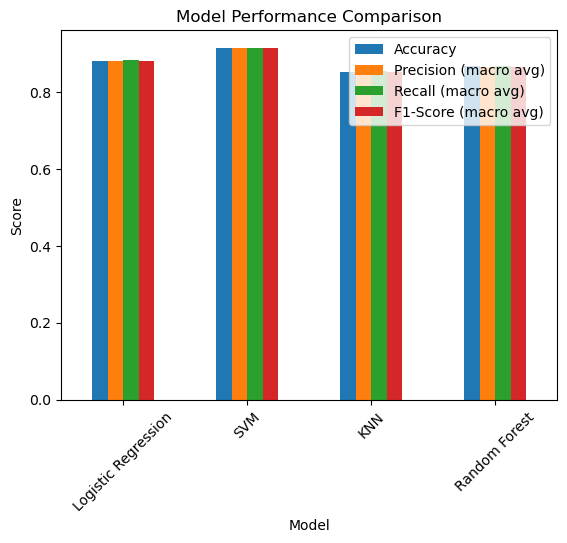

In [17]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import seaborn as sns
import pickle
import matplotlib.pyplot as plt
import os

# Ensure directory for saving model files
MODEL_DIR = "backend/model"
os.makedirs(MODEL_DIR, exist_ok=True)

# ✅ 1️⃣ Ensure label encoding consistency
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_balanced)
y_test_encoded = label_encoder.transform(y_test)


# ✅ 2️⃣ Initialize results dictionary
results = []

# ✅ 3️⃣ Helper function to evaluate models and store results
def evaluate_model(name, model, X_test, y_test):
    print(f"Evaluating model: {name}")

    # Make predictions
    y_pred = model.predict(X_test)

    # Ensure predictions are encoded the same way as training labels
    if isinstance(y_pred[0], str):
        y_pred = label_encoder.transform(y_pred)

    print(f"y_test type: {type(y_test[0])}, unique values: {np.unique(y_test)}")
    print(f"y_pred type: {type(y_pred[0])}, unique values: {np.unique(y_pred)}")

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)

    # Store results
    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision (macro avg)": report["macro avg"]["precision"],
        "Recall (macro avg)": report["macro avg"]["recall"],
        "F1-Score (macro avg)": report["macro avg"]["f1-score"],
    })

# ✅ 4️⃣ Evaluate all models
evaluate_model("Logistic Regression", log_reg, X_test_scaled, y_test_encoded)
evaluate_model("SVM", svm, X_test_scaled, y_test_encoded)
evaluate_model("KNN", knn, X_test_scaled, y_test_encoded)
evaluate_model("Random Forest", rf, X_test_scaled, y_test_encoded)

# ✅ 5️⃣ Create a DataFrame for results
results_df = pd.DataFrame(results)

# Sort results by Accuracy (descending order)
pd.set_option('display.expand_frame_repr', False)
results_df = results_df.sort_values(by="Accuracy", ascending=False)
print("\nModel Comparison:")
print(results_df)

# Ensure results are stored in a DataFrame
results_df = pd.DataFrame(results)

# Save results for React visualization
results_df.to_csv("backend/public/model_performance.csv", index=False)

print("✅ Model performance data saved to backend/public/model_performance.csv")


# Ensure a directory for saving images
CONF_MATRIX_DIR = "backend/public/confusion_matrices"
os.makedirs(CONF_MATRIX_DIR, exist_ok=True)

# ✅ 6️⃣ Identify the best model
best_model_row = results_df.iloc[0]
best_model_name = best_model_row["Model"]
print(f"\n✅ Best Model: {best_model_name} with Accuracy: {best_model_row['Accuracy']:.2f}")

# ✅ 7️⃣ Model Selection Dictionary (Move this up before using models)
models = {
    "Logistic Regression": log_reg,
    "SVM": svm,
    "KNN": knn,
    "Random Forest": rf,
}

# ✅ 8️⃣ Save the best model
MODEL_PATH = os.path.join(MODEL_DIR, "model.pkl")
with open(MODEL_PATH, "wb") as model_file:
    pickle.dump(models[best_model_name], model_file)

print(f"✅ Best model saved successfully at {MODEL_PATH}")

# ✅ 9️⃣ Generate and Save Confusion Matrices
CONF_MATRIX_DIR = "backend/public/confusion_matrices"
os.makedirs(CONF_MATRIX_DIR, exist_ok=True)

confusion_matrices = {}

for model_name, model in models.items():
    y_pred = model.predict(X_test_scaled)
    
    # ✅ Convert predictions to numeric labels if needed
    if isinstance(y_pred[0], str):
        y_pred = label_encoder.transform(y_pred)  # Convert string labels to numeric

    cm = confusion_matrix(y_test_encoded, y_pred)  # Compute confusion matrix
    confusion_matrices[model_name] = cm

    # Save confusion matrix as image
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {model_name}")
    save_path = os.path.join(CONF_MATRIX_DIR, f"confusion_matrix_{model_name}.png")
    plt.savefig(save_path)  # Save image for React
    plt.close()

print(f"✅ Confusion matrices saved to {CONF_MATRIX_DIR}")


# ✅ 9️⃣ Visualize results
plt.figure(figsize=(10, 6))
results_df.set_index("Model").plot(kind="bar")
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(loc="upper right")
plt.show()

## Step 8 : Checking Output using Best Model

In [19]:
# import os
# import random
# import numpy as np
# import librosa
# from sklearn.preprocessing import StandardScaler

# # Path to the unused dataset folder
# new_data_folder = './unused_dataset'

# # Emotion mapping based on file prefixes
# emotion_mapping = {
#     "angry": "Angry",
#     "disgust": "Disgust",
#     "fear": "Fear",
#     "neutral": "Neutral",
#     "ps": "Pleasant Surprise",
#     "pleasant_surprise": "Pleasant Surprise",
#     "sad": "Sad",
#     "happy": "Happy"
# }

# # Function to extract MFCC features
# def extract_features(file_path, n_mfcc=10):
#     y, sr = librosa.load(file_path, sr=None)
#     mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
#     return np.mean(mfcc.T, axis=0)

# # Preprocessing and predicting for Logistic Regression, SVM, KNN, and Random Forest
# def run_ml_model(model, file_paths, n_mfcc=10):
#     # Extracting features
#     features = np.array([extract_features(file, n_mfcc=n_mfcc) for file in file_paths])
    
#     # Standardizing the features
#     scaler = StandardScaler()
#     features = scaler.fit_transform(features)
    
#     # Predicting using the model
#     predicted_labels = model.predict(features)
#     return predicted_labels

# # Extract emotion from file name
# def extract_emotion_from_filename(file_name):
#     for key in emotion_mapping.keys():
#         if key in file_name.lower():
#             return emotion_mapping[key]
#     return "Unknown"

# # Selecting 3 random files for testing
# all_files = [os.path.join(new_data_folder, f) for f in os.listdir(new_data_folder) if f.endswith('.wav')]
# selected_files = random.sample(all_files, min(3, len(all_files)))

# # Models dictionary
# models = {
#     "Logistic Regression": log_reg,
#     "SVM": svm,
#     "KNN": knn,
#     "Random Forest": rf,
# }

# # Determining the best model dynamically
# best_model_row = results_df.iloc[0]
# best_model_name = best_model_row["Model"]
# print(f"\nBest Model: {best_model_name} with Accuracy: {best_model_row['Accuracy']:.2f}")

# # Selecting the best model
# best_model = models[best_model_name]

# # Predicting emotions using the best model
# predicted_labels = run_ml_model(best_model, selected_files)

# # Display predictions
# for file, label in zip(selected_files, predicted_labels):
#     emotion = extract_emotion_from_filename(file)
#     print(f"File: {os.path.basename(file)} --> Predicted Emotion: {emotion}")